# BERT

In [2]:
import sys
import os

# Get the current working directory
notebook_dir = os.getcwd()

# Construct the path to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add the parent directory to the system path
sys.path.append(parent_dir)

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers import Adam

from preprocessing import preprocess_df
from utils import get_x_y, stratified_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score

2024-05-22 19:14:23.443571: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 19:14:23.481481: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-22 19:14:23.482169: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 19:14:24.731108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(np.array(y_true), y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def roc_score(model_name, y_true, y_pred_proba):
    """
    Plots the ROC curve for the given model and data. Calculates and prints the area under the ROC curve.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    print(f'AUC: {auc}')
    plt.plot(fpr, tpr, label=model_name+" AUC="+str(round(auc, 3)))
    plt.legend(loc='best')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve for {model_name}')
    plt.show()

def validate_model_bert(bert, x_test, y_true):
    print('#### VALIDATION ####')

    predictions_proba = bert.predict(x_test)
    y_pred = np.where(predictions_proba.max(axis=-1) > 0.5, 1, 0)

    print('Classification report:')
    print(classification_report(y_true, y_pred, zero_division=0))
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print('Recall: ', recall_score(y_true, y_pred))
    print('F1-score: ', f1_score(y_true, y_pred))

    conf_matrix(y_true, y_pred)
    roc_score('BERT', y_true, predictions_proba.flatten())

# BERT Shuffled

In [23]:
df = pd.read_csv(os.path.join('..', 'data', 'preprocessed_df.csv'), header=0)
df.head()

,title,text,generated,preprocessed_text
0,Sexhow railway station,Sexhow railway station was a railway station b...,0,sexhow railway station railway station built s...
1,Etiäinen,"In Finnish folklore, all places and things, an...",0,finnish folklore place thing also human being ...
2,Inverse function theorem,"In mathematics, specifically differential calc...",0,mathematics specifically differential calculus...
3,Stepping on Roses,is a Japanese shōjo manga series written and i...,0,japanese shōjo manga series written illustrate...
4,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0,robert milner rob bradley born august 1970 gre...


In [24]:
# split data
train_set, valid_set, test_set = stratified_split(df)

# shuffle rows
train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)

x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

In [5]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

params_dict = {'learning_rate': 2e-5,
                   'epochs': 3,
                   'batch': 16}

In [6]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [8]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
optimizer = Adam(learning_rate=params_dict['learning_rate'])

In [9]:
classifier_model = build_classifier_model()
classifier_model.summary()
#tf.keras.utils.plot_model(classifier_model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [10]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [14]:
history = classifier_model.fit(x=x_train,
                               y=y_train,
                               validation_data=(x_valid, y_valid),
                               epochs=params_dict['epochs'])

Epoch 1/3
2813/2813 [==============================] - 9364s 3s/step - loss: 0.0950 - binary_accuracy: 0.9623 - val_loss: 0.0650 - val_binary_accuracy: 0.9788
Epoch 2/3
2813/2813 [==============================] - 9252s 3s/step - loss: 0.0253 - binary_accuracy: 0.9908 - val_loss: 0.1436 - val_binary_accuracy: 0.9596
Epoch 3/3
2813/2813 [==============================] - 9300s 3s/step - loss: 0.0134 - binary_accuracy: 0.9952 - val_loss: 0.1755 - val_binary_accuracy: 0.9562


In [15]:
classifier_model.save('models/bert_shuffled.h5')

/home/mfain/anaconda/envs/bert-venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### VALIDATION ####
938/938 [==============================] - 919s 979ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     15000
           1       0.92      1.00      0.96     15000

    accuracy                           0.96     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000



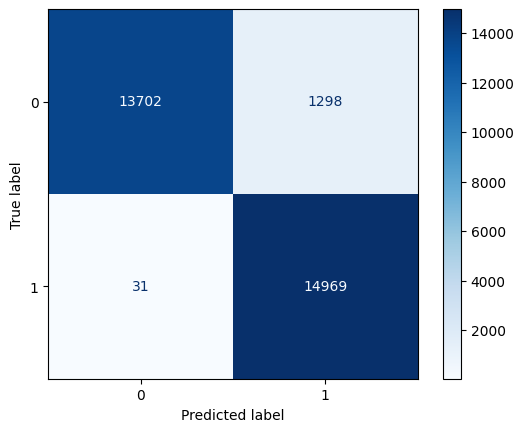

In [16]:
validate_model_bert(classifier_model, x_test, y_test)

In [21]:
reloaded_bert = tf.keras.models.load_model(('models/bert_shuffled.h5'), custom_objects={'KerasLayer': hub.KerasLayer})

2024-05-21 22:55:19.145708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 22:55:19.147836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 22:55:19.169561: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

938/938 [==============================] - 1249s 1s/step
Accuracy:  0.9557
Recall:  0.9979333333333333
F1-score:  0.9574951226532766
AUC: 0.9990106044444444


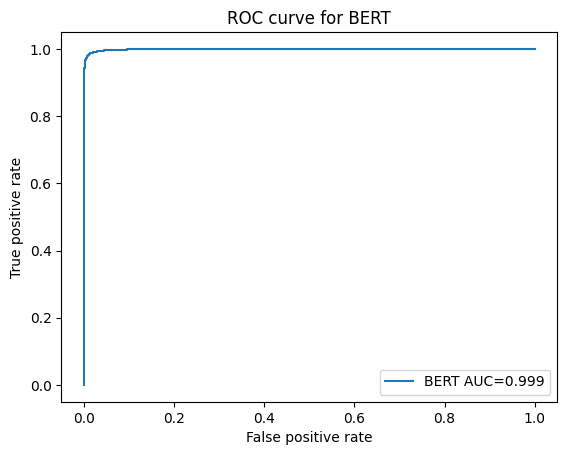

In [38]:
predictions_proba = reloaded_bert.predict(x_test)
predictions = np.where(predictions_proba.max(axis=-1) > 0.5, 1, 0)

print('Accuracy: ', accuracy_score(y_test, predictions))
print('Recall: ', recall_score(y_test, predictions))
print('F1-score: ', f1_score(y_test, predictions))
roc_score('BERT', y_test, predictions_proba.flatten())

# Predicting on Different Data

In [18]:
def predict_data(model, data):
    # prepare data
    data = preprocess_df(data)
    x = data['preprocessed_text']
    y = np.array(data['generated'])
    
    validate_model_bert(model, x, y)

#### VALIDATION ####
44/44 [==============================] - 42s 963ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.96      1375
           1       0.02      0.67      0.03         3

    accuracy                           0.91      1378
   macro avg       0.51      0.79      0.49      1378
weighted avg       1.00      0.91      0.95      1378



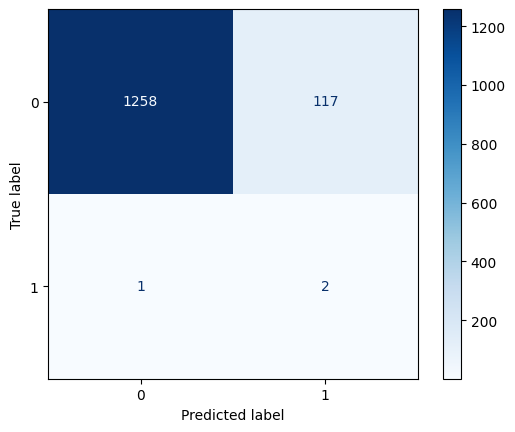

In [18]:
df_essays = pd.read_csv(os.path.join('..', 'data', 'extras', 'train_essays.csv'), header=0)
predict_data(classifier_model, df_essays)

In [19]:
df_palm = pd.read_csv(os.path.join('..', 'data', 'extras', 'LLM_generated_essay_PaLM.csv'), header=0)
df_falcon = pd.read_csv(os.path.join('..', 'data', 'extras', 'falcon_180b_v1.csv'), header=0)
df_llama = pd.read_csv(os.path.join('..', 'data', 'extras', 'llama_70b_v1.csv'), header=0)

df_llama.rename(columns={'generated_text': 'text'}, inplace=True)
df_falcon.rename(columns={'generated_text': 'text'}, inplace=True)

df_falcon['generated'] = np.ones(df_falcon.shape[0])
df_llama['generated'] = np.ones(df_llama.shape[0])

df_extras = pd.concat([df_palm[['text', 'generated']], df_falcon[['text', 'generated']], df_llama[['text', 'generated']]], axis=0)
print(df_extras.shape)
df_extras.head()

(3611, 2)


,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0


#### VALIDATION ####
113/113 [==============================] - 111s 987ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.82      0.90      3611

    accuracy                           0.82      3611
   macro avg       0.50      0.41      0.45      3611
weighted avg       1.00      0.82      0.90      3611



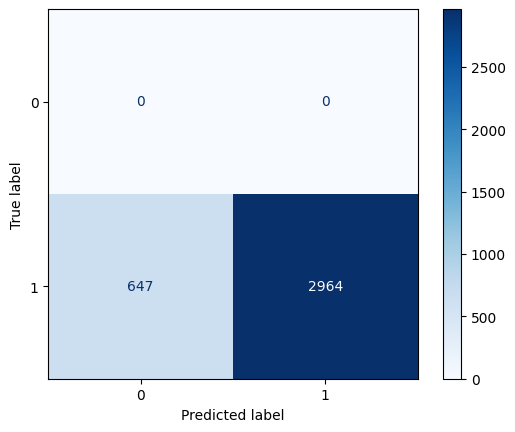

In [20]:
predict_data(classifier_model, df_extras)